In [1]:
from sys import path
path.append('../src/')

# mandatory imports
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
from data_structures import Point, Rect

# optional imports
import matplotlib.pyplot as plt
from iso_standard import PhotographicRequirements

Using TensorFlow backend.


# Utils 

In [2]:
def load_graph_from_pb(pb_file):
    graph = tf.Graph()

    graph_def = tf.GraphDef()
    graph_def.ParseFromString(open(pb_file, 'rb').read())

    with graph.as_default():
        tf.import_graph_def(graph_def)
    return graph


def run_graph(graph, inputs_list, input_tensor_names, output_tensor_names):
    assert(len(inputs_list) == len(input_tensor_names))

    with tf.Session(graph=graph) as sess:
        input_tensors = [graph.get_tensor_by_name(name) for name in input_tensor_names]
        output_tensors = [graph.get_tensor_by_name(name) for name in output_tensor_names]
        feed_dict = {tensor:value for tensor, value in zip(input_tensors, inputs_list)}
        return sess.run(output_tensors, feed_dict=feed_dict)


def run_face_detector(bgr_image):
    img = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    img = img.astype(np.uint8)
    height, width = img.shape[:2]

    inputs_list = [np.expand_dims(img, axis=0)]
    input_tensor_names = ["import/image_tensor:0"]
    output_tensor_names = ["import/detection_boxes:0", "import/detection_scores:0"]
    boxes, scores = run_graph(
        face_detector, inputs_list, input_tensor_names, output_tensor_names
    )

    best_rect = boxes.squeeze()[scores.squeeze().argmax()]
    best_rect = best_rect * [height, width, height, width]
    best_rect = best_rect.astype(np.int)
    y1, x1, y2, x2 = best_rect
    return Rect.from_tl_br_points((x1, y1), (x2, y2))


def preprocessing(bgr_image):
    face_rect = run_face_detector(bgr_image)
    w, h = face_rect.width, face_rect.height

    pad_rect = Rect(face_rect.x, face_rect.y, w + int(w * 1.5), h + int(h * 1.5))
    pad_rect.height = pad_rect.width = max(pad_rect.height, pad_rect.width)

    center_pad = Point(
        (pad_rect.x + pad_rect.width) // 2, (pad_rect.y + pad_rect.height) // 2
    )
    center_face = Point(
        (face_rect.x + face_rect.width) // 2, (face_rect.y + face_rect.height) // 2
    )
    offset_center = Point(center_face.x - center_pad.x, center_face.y - center_pad.y)
    pad_rect += offset_center

    im_h, im_w = bgr_image.shape[:2]
    br_x, br_y = pad_rect.br()
    left = abs(min(0, pad_rect.x))
    top = abs(min(0, pad_rect.y))
    right = 0 if br_x < im_w else br_x - im_w
    bottom = 0 if br_y < im_h else br_y - im_h

    im_res = cv2.copyMakeBorder(
        bgr_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0
    )
    pad_rect.x += left
    pad_rect.y += top

    l, t = pad_rect.tl()
    r, b = pad_rect.br()
    return im_res[t:b, l:r]

# Resources

In [3]:
face_detector = load_graph_from_pb("../resources/models/face_detector.pb")
icaonet = load_model("../resources/models/icaonet.h5", compile=False) # reqs branch only

Instructions for updating:
Colocations handled automatically by placer.


# Inference


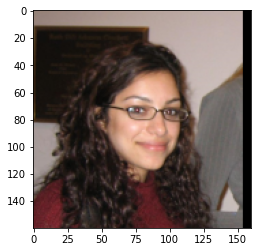

In [4]:
filepath = "C://Users//arnal//Desktop//doutorado//FVC/afwDB_0.png"

im = cv2.imread(filepath, cv2.IMREAD_ANYCOLOR)
im = preprocessing(im)
im = cv2.resize(im, (160, 160), interpolation=cv2.INTER_AREA).astype(np.float32)
im = np.expand_dims(im, axis=0)
im = im / 255

plt.imshow(im[0, :, :, ::-1])

In [5]:
y_pred = icaonet.predict([im])
y_pred

array([[0.64809203, 0.9347415 , 0.99573874, 0.08281666, 0.991169  ,
        0.9998725 , 0.9772672 , 0.27883738, 0.96358013, 0.05340803,
        0.2058002 , 0.14253008, 0.9828384 , 0.47127613, 0.82925045,
        0.9903072 , 0.75461185, 0.97962976, 0.8930521 , 0.6584907 ,
        0.9751569 , 0.827954  , 0.9905076 ]], dtype=float32)

### Optional

In [6]:
# optional
reqs = PhotographicRequirements(*y_pred.squeeze())
print(reqs)

[02] Blurred: 0.6480920314788818
[03] Looking away: 0.9347414970397949
[04] Ink marked/creased: 0.9957387447357178
[05] Unnatural skin tone: 0.08281666040420532
[06] Too dark/light: 0.9911689758300781
[07] Washed out: 0.9998725056648254
[08] Pixelation: 0.9772672057151794
[09] Hair across eyes: 0.2788373827934265
[10] Eyes closed: 0.9635801315307617
[11] Varied background: 0.053408026695251465
[12] Roll/pitch/yaw rotations greater than a predefined thresholds: 0.20580020546913147
[13] Flash reflection on skin: 0.14253008365631104
[14] Red eyes: 0.9828383922576904
[15] Shadows behind head: 0.4712761342525482
[16] Shadows across face: 0.8292504549026489
[17] Dark tinted lenses: 0.9903072118759155
[18] Flash reflection on lenses: 0.7546118497848511
[19] Frames too heavy: 0.9796297550201416
[20] Frame covering eyes: 0.8930521011352539
[21] Hat/cap: 0.6584907174110413
[22] Veil over face: 0.9751569032669067
[23] Mouth open: 0.8279539942741394
[24] Presence of other faces or toys too close t

In [7]:
# you can get the score for each individual requirement
print(reqs.blurred.value)

0.64809203


In [8]:
# you can also iter through requirements
for req in reqs:
    print(req.value)

0.64809203
0.9347415
0.99573874
0.08281666
0.991169
0.9998725
0.9772672
0.27883738
0.96358013
0.053408027
0.2058002
0.14253008
0.9828384
0.47127613
0.82925045
0.9903072
0.75461185
0.97962976
0.8930521
0.6584907
0.9751569
0.827954
0.9905076


In [9]:
# useful methods
print(reqs.blurred.is_compliant(threshold=0.5)) # default threshold = 0.5
print(reqs.varied_background.is_non_compliant(threshold=0.5))

True
True
